In [9]:
import yfinance as yf
import pandas as pd
from finta import TA
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def create_ta_features(ticker='^GSPC', start_='2010-01-01', end_='2022-12-31', interval_='1d', fillna=True, scale_to_std=True, fill_weekends=True):
    """
    Creates dataframe with technical analysis features
    :param ticker: ticker symbol to download data for (default is S&P 500)
    :param start_: start date
    :param end_: end date
    :param interval_: data frequency
    :param fillna: whether to fill in missing values
    :param scale_to_std: whether to scale to standard deviation
    :param fill_weekends: whether to fill in weekends
    :return: dataframe with technical analysis features
    """
    # download data
    df = yf.download(ticker, start_, end_, interval=interval_)
    # rename columns
    df.rename(columns={"Open": "open", "Adj Close": "close", "High": "high", "Low": "low", "Volume": "volume"}, inplace=True)
    # drop close column
    df.drop("Close", inplace=True, axis=1)
    # fill weekends
    if fill_weekends:
        df = df.resample('D').ffill()
    # get all functions in finta
    finta_functions = [func for func in dir(TA) if callable(getattr(TA, func)) and not func.startswith("__")]
    # loop through all functions in finta and append the results to the dataframe
    # skip functions that throw errors
    for func in finta_functions:
        try:
            df[func] = getattr(TA, func)(df)
        except:
            pass
    # fill in missing values
    if fillna:
        df.fillna(method='bfill', inplace=True)
        df.fillna(method='ffill', inplace=True)
    # scale to standard deviation, by column
    if scale_to_std:
        df = (df - df.mean()) / df.std()
    return df

In [11]:
# function that adds sine and cosine of weekday, monthday, yearday to dataframe
# takes into account whether the data is daily, hourly, minutely, etc.
# also takes into account whether data includes weekends or not
# if data does not include weekends, assume the week is 5 days, not 7, month is 21 days, not 31, and year is 250 days, not 365
def add_time_features(df):
    """
    Adds sine and cosine of weekday, monthday, yearday to dataframe
    :param df: dataframe to add time features to
    :return: dataframe with time features
    """
    # get frequency of data
    freq = pd.infer_freq(df.index)
    # if frequency is daily, assume data includes weekends
    if freq == 'D':
        include_weekends = True
    else:
        include_weekends = False

    # get number of days in week, month, year
    if include_weekends:
        days_in_week = 7
        days_in_month = 31
        days_in_year = 365
    else:
        days_in_week = 5
        days_in_month = 21
        days_in_year = 250
    # add weekday, monthday, yearday features
    df['weekday'] = df.index.dayofweek
    df['monthday'] = df.index.day
    df['yearday'] = df.index.dayofyear
    # add sine and cosine of weekday, monthday, yearday features
    df['sin_weekday'] = np.sin(2 * np.pi * df['weekday'] / days_in_week)
    df['cos_weekday'] = np.cos(2 * np.pi * df['weekday'] / days_in_week)
    df['sin_monthday'] = np.sin(2 * np.pi * df['monthday'] / days_in_month)
    df['cos_monthday'] = np.cos(2 * np.pi * df['monthday'] / days_in_month)
    df['sin_yearday'] = np.sin(2 * np.pi * df['yearday'] / days_in_year)
    df['cos_yearday'] = np.cos(2 * np.pi * df['yearday'] / days_in_year)
    # drop weekday, monthday, yearday features
    df.drop(['weekday', 'monthday', 'yearday'], inplace=True, axis=1)
    return df

In [12]:
# a function that takes a dataframe and implements a sliding window mechanism with a given window size
# return a list of windows as dataframes
def sliding_window(df, window_size=10):
    """
    Creates a sliding window mechanism for a given dataframe
    :param df: dataframe
    :param window_size: window size
    :return: list of windows as dataframes
    """
    windows = []
    for i in range(len(df) - window_size + 1):
        windows.append(df.iloc[i:i + window_size])
    return windows

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import decomposition

#### garbage pca

In [27]:
sp500_df = create_ta_features(fill_weekends=False)
sp500_df.head(20)

[*********************100%***********************]  1 of 1 completed


C:\Users\Pawel\PycharmProjects\FinDL\venv\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Pawel\PycharmProjects\FinDL\venv\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Pawel\PycharmProjects\FinDL\venv\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Pawel\PycharmProjects\FinDL\venv\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Pawel\PycharmProjects\FinDL\venv\li

,open,high,low,close,volume,ADL,ADX,AO,ATR,BBWIDTH,...,VAMA,VBM,VFI,VPT,VWAP,VZO,WILLIAMS,WMA,WOBV,ZLEMA
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,-1.298686,-1.286505,-1.293132,-1.282682,0.057434,-1.916319,7.381934,-0.234498,-0.653191,0.683799,...,-1.286692,0.747361,-1.050971,-1.895904,-1.302407,-0.295221,-1.980814,-1.271013,-1.099913,-1.313648
2010-01-05,-1.282409,-1.283732,-1.279795,-1.279113,-1.483494,-1.910779,7.381934,-0.234498,-0.653191,0.683799,...,-1.286692,0.747361,-1.050971,-1.889920,-1.295902,1.288806,-1.980814,-1.271013,-1.099913,-1.313648
2010-01-06,-1.279326,-1.281159,-1.275428,-1.278486,1.065213,-1.908295,7.381934,-0.234498,-0.653191,0.683799,...,-1.286692,0.747361,-1.050971,-1.884033,-1.288545,2.368653,-1.980814,-1.271013,-1.098161,-1.313648
2010-01-07,-1.278759,-1.277874,-1.278105,-1.273885,1.371287,-1.897865,7.381934,-0.234498,-0.653191,0.683799,...,-1.286692,0.747361,-1.050971,-1.872910,-1.284095,2.788762,-1.980814,-1.271013,-1.084537,-1.313648
2010-01-08,-1.274463,-1.274930,-1.273117,-1.270558,0.466385,-1.888687,7.381934,-0.234498,-0.653191,0.683799,...,-1.286692,0.747361,-1.050971,-1.863650,-1.280066,2.974177,-1.980814,-1.271013,-1.076332,-1.313648
2010-01-11,-1.268963,-1.270559,-1.267212,-1.268536,0.328959,-1.885902,7.381934,-0.234498,-0.653191,0.683799,...,-1.286692,0.747361,-1.050971,-1.861210,-1.275712,3.091776,-1.980814,-1.271013,-1.071497,-1.313648
2010-01-12,-1.271137,-1.276517,-1.277647,-1.279416,0.801781,-1.888726,7.381934,-0.234498,-0.653191,0.683799,...,-1.286692,0.747361,-1.050971,-1.874107,-1.276012,1.469591,-1.980814,-1.271013,-1.100326,-1.313648
2010-01-13,-1.277708,-1.271906,-1.276212,-1.269850,0.241230,-1.882573,7.381934,-0.234498,-0.653191,0.683799,...,-1.286692,0.747361,-1.050971,-1.864159,-1.274566,1.848202,-1.980814,-1.271013,-1.077913,-1.313648
2010-01-14,-1.269246,-1.269886,-1.265400,-1.267039,-0.020825,-1.878887,7.381934,-0.234498,-0.653191,0.683799,...,-1.286692,0.747361,-1.050971,-1.857016,-1.272115,2.125158,-1.980814,-1.271013,-1.071730,-1.313648


In [28]:
arr = []
for col in range(len(sp500_df.columns)):

    pca = decomposition.PCA(n_components=col+1)
    pc = pca.fit_transform(sp500_df)
    arr.append(pca.explained_variance_ratio_.sum())

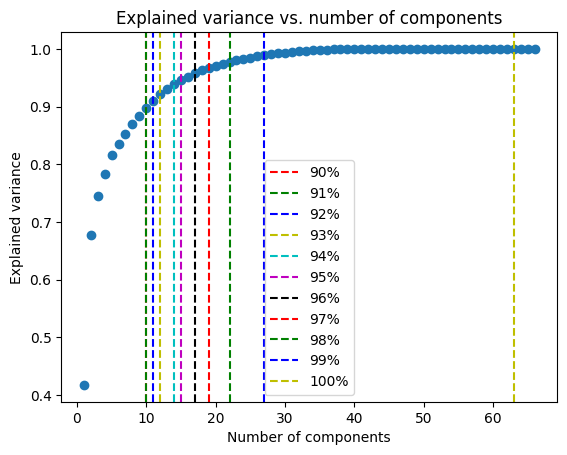

90% variance explained by 10 components
91% variance explained by 10 components
92% variance explained by 11 components
93% variance explained by 12 components
94% variance explained by 14 components
95% variance explained by 15 components
96% variance explained by 17 components
97% variance explained by 19 components
98% variance explained by 22 components
99% variance explained by 27 components
100% variance explained by 63 components


In [33]:
# plot arr and see how many components we need to explain 90%, 91%, 92%, etc. of the variance
var_90 = np.where(np.array(arr) >= 0.9)[0][0]
var_91 = np.where(np.array(arr) >= 0.91)[0][0]
var_92 = np.where(np.array(arr) >= 0.92)[0][0]
var_93 = np.where(np.array(arr) >= 0.93)[0][0]
var_94 = np.where(np.array(arr) >= 0.94)[0][0]
var_95 = np.where(np.array(arr) >= 0.95)[0][0]
var_96 = np.where(np.array(arr) >= 0.96)[0][0]
var_97 = np.where(np.array(arr) >= 0.97)[0][0]
var_98 = np.where(np.array(arr) >= 0.98)[0][0]
var_99 = np.where(np.array(arr) >= 0.99)[0][0]
var_100 = np.where(np.array(arr) >= 1.0)[0][0]
plt.scatter(range(1, len(sp500_df.columns)+1), arr)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Explained variance vs. number of components')
plt.axvline(x=var_90, color='r', linestyle='--', label='90%')
plt.axvline(x=var_91, color='g', linestyle='--', label='91%')
plt.axvline(x=var_92, color='b', linestyle='--', label='92%')
plt.axvline(x=var_93, color='y', linestyle='--', label='93%')
plt.axvline(x=var_94, color='c', linestyle='--', label='94%')
plt.axvline(x=var_95, color='m', linestyle='--', label='95%')
plt.axvline(x=var_96, color='k', linestyle='--', label='96%')
plt.axvline(x=var_97, color='r', linestyle='--', label='97%')
plt.axvline(x=var_98, color='g', linestyle='--', label='98%')
plt.axvline(x=var_99, color='b', linestyle='--', label='99%')
plt.axvline(x=var_100, color='y', linestyle='--', label='100%')
plt.legend()
plt.show()
print('90% variance explained by {} components'.format(var_90))
print('91% variance explained by {} components'.format(var_91))
print('92% variance explained by {} components'.format(var_92))
print('93% variance explained by {} components'.format(var_93))
print('94% variance explained by {} components'.format(var_94))
print('95% variance explained by {} components'.format(var_95))
print('96% variance explained by {} components'.format(var_96))
print('97% variance explained by {} components'.format(var_97))
print('98% variance explained by {} components'.format(var_98))
print('99% variance explained by {} components'.format(var_99))
print('100% variance explained by {} components'.format(var_100))

In [36]:
pca = decomposition.PCA(n_components=len(sp500_df.columns))
pc = pca.fit_transform(sp500_df)
pd.DataFrame(pca.components_,columns=sp500_df.columns)

,open,high,low,close,volume,ADL,ADX,AO,ATR,BBWIDTH,...,VAMA,VBM,VFI,VPT,VWAP,VZO,WILLIAMS,WMA,WOBV,ZLEMA
0,0.189449,0.189564,0.189222,0.189356,3.992624e-02,1.838202e-01,-1.497125e-02,4.004766e-04,1.279352e-01,2.436423e-02,...,1.897737e-01,1.764797e-02,1.749747e-02,1.846053e-01,1.871008e-01,-2.481127e-02,-0.006084,1.897000e-01,1.660341e-01,1.896138e-01
1,-0.022082,-0.021194,-0.024385,-0.023384,7.174366e-02,-1.504181e-02,3.740450e-02,-1.807967e-01,8.600499e-02,7.954314e-02,...,-1.739283e-02,7.052693e-02,-7.045193e-02,-1.673950e-02,-3.928290e-03,-1.815812e-01,-0.206672,-1.874680e-02,-6.035596e-02,-1.872292e-02
2,-0.014760,-0.011621,-0.016054,-0.012612,2.097388e-01,-6.635554e-03,1.402504e-01,-1.814109e-01,2.721934e-01,3.904819e-01,...,-1.660016e-02,3.133634e-01,-1.691194e-01,-9.463133e-03,3.005309e-02,1.104729e-01,0.137917,-1.609014e-02,-1.405894e-01,-2.088983e-02
3,-0.004573,-0.006750,-0.009823,-0.011358,1.545865e-01,-1.355749e-02,1.321258e-01,1.179262e-01,-1.509443e-02,1.277860e-01,...,2.251608e-03,1.752291e-03,-2.009924e-02,-1.581273e-02,4.215183e-03,-1.049533e-01,-0.180294,2.069048e-04,-5.668279e-02,4.240384e-03
4,-0.006727,-0.006040,-0.006028,-0.005018,-5.547823e-02,-2.778069e-03,1.940436e-01,-2.183398e-01,-5.789701e-02,-2.173705e-02,...,-1.051393e-03,-2.917305e-01,2.366392e-01,-2.036460e-03,-3.676117e-02,2.162584e-01,0.053128,-2.351299e-03,6.894841e-02,-2.462455e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.002165,-0.002035,0.004325,0.002918,-1.148167e-05,-5.643997e-04,1.248552e-04,3.505057e-03,2.158465e-04,-2.451922e-05,...,-4.868642e-02,-3.130277e-04,4.932721e-05,-5.495646e-04,1.136270e-03,2.475018e-04,-0.000067,8.432967e-01,3.345578e-02,2.219318e-02
62,-0.000909,0.000961,0.002897,-0.008775,6.117133e-06,-5.773019e-04,-1.914387e-05,-5.223670e-04,-9.103593e-05,9.040981e-05,...,-8.681269e-03,-1.890004e-05,-2.622107e-05,4.810393e-04,3.925570e-04,3.160700e-06,-0.000025,1.110678e-01,2.918767e-03,8.753258e-02
63,-0.001861,0.000474,0.001061,-0.007438,2.972257e-06,3.484822e-04,5.390396e-06,-4.194247e-04,-1.577201e-06,-3.416227e-05,...,-6.387769e-03,1.252780e-05,1.189111e-05,-1.927515e-04,-3.325985e-04,4.274024e-05,0.000007,1.072940e-01,2.421646e-03,2.971672e-02
64,-0.000000,0.278542,0.274904,0.276771,-4.163336e-17,-2.432082e-15,-1.387779e-17,-1.582068e-15,2.844947e-16,-1.804112e-16,...,1.604966e-14,-2.428613e-17,-1.075529e-16,3.590878e-15,-3.851086e-16,-4.857226e-17,-0.201326,-2.053427e-13,-1.679212e-15,-3.442385e-14


In [37]:
sns.pairplot(sp500_df)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000002A6DBC32170> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x000002A6FD9BCF70> (for post_execute):


KeyboardInterrupt: 

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

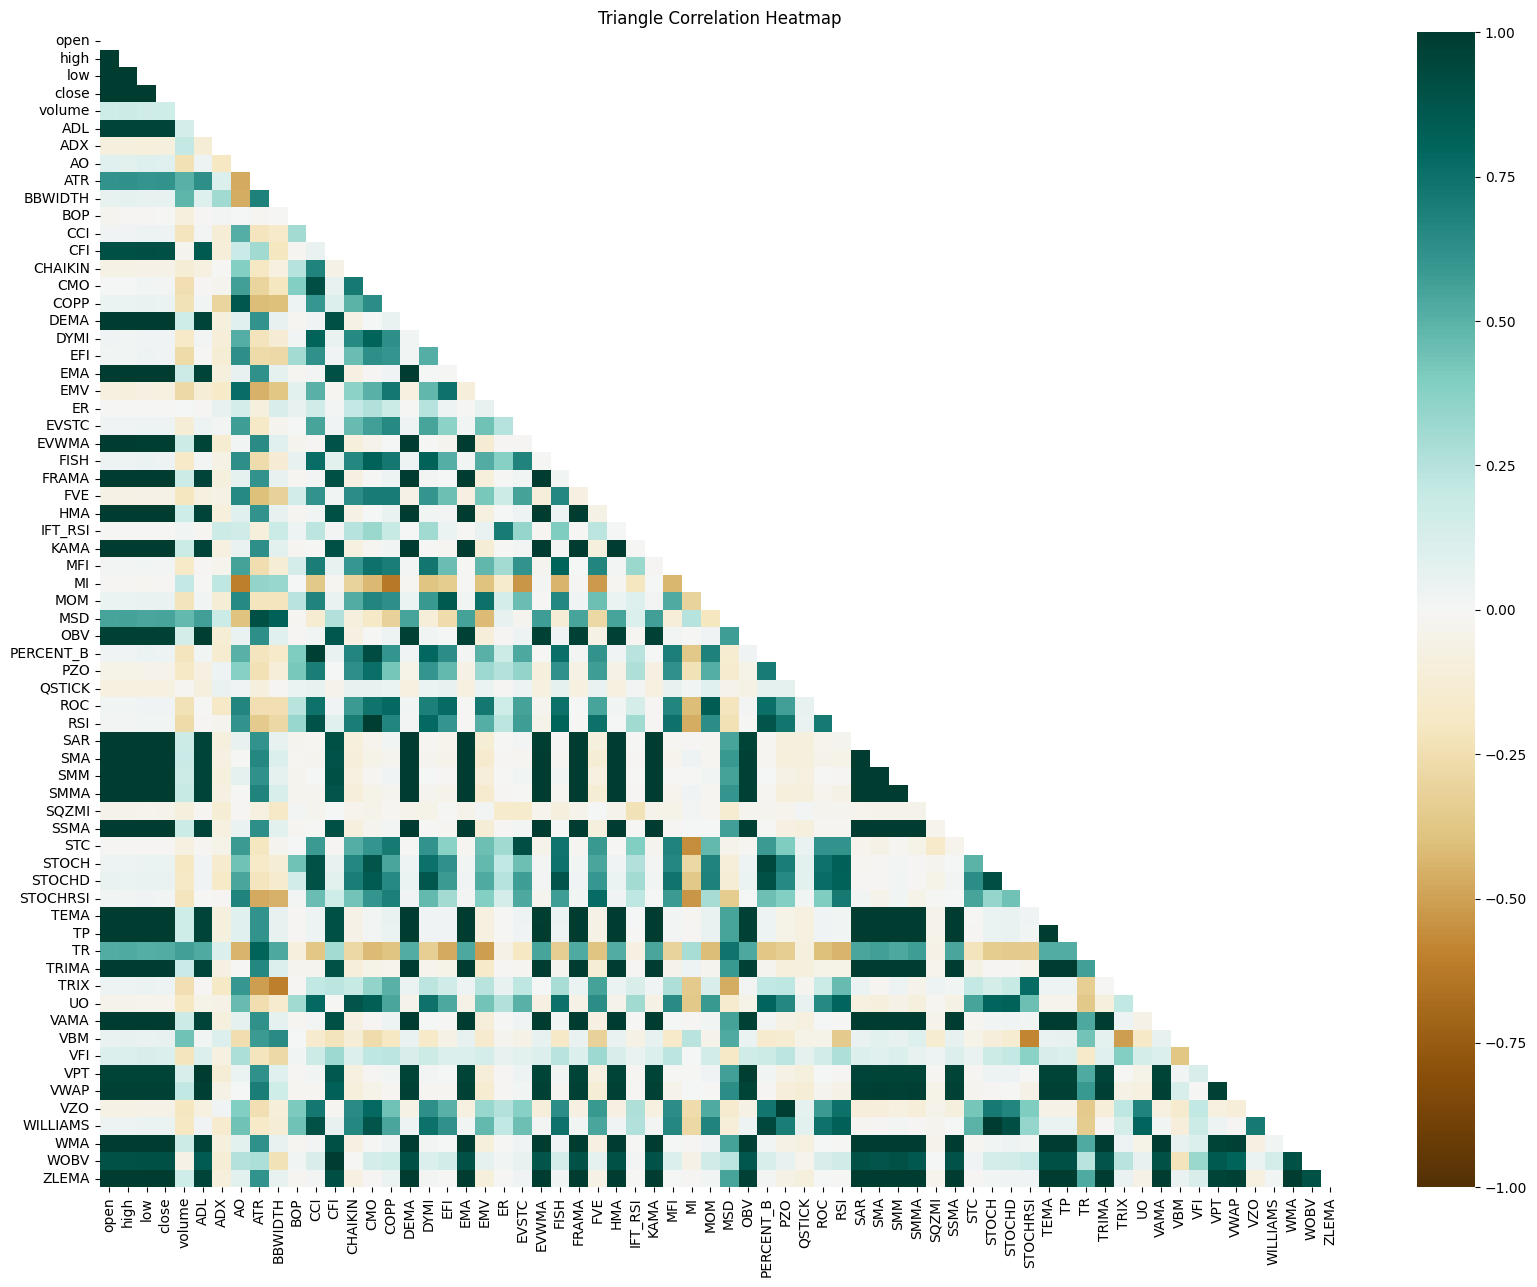

In [43]:
plt.figure(figsize=(20,15))# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(sp500_df.corr(), dtype=bool))
heatmap = sns.heatmap(sp500_df.corr(), mask=mask, vmin=-1, vmax=1, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap')

In [30]:
sp500_df_with_time = add_time_features(sp500_df)
sp500_df_with_time.head(20)

,open,high,low,close,volume,ADL,ADX,AO,ATR,BBWIDTH,...,WILLIAMS,WMA,WOBV,ZLEMA,sin_weekday,cos_weekday,sin_monthday,cos_monthday,sin_yearday,cos_yearday
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,-1.299113,-1.286708,-1.293664,-1.282928,0.049746,-1.833595,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.100389,-1.275609,0.000000,1.000000,0.724793,0.688967,0.068802,0.997630
2010-01-05,-1.282826,-1.283933,-1.280318,-1.279357,-1.377868,-1.830133,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.100389,-1.275609,0.781831,0.623490,0.848644,0.528964,0.085965,0.996298
2010-01-06,-1.279741,-1.281359,-1.275947,-1.278730,0.983417,-1.828580,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.098638,-1.275609,0.974928,-0.222521,0.937752,0.347305,0.103102,0.994671
2010-01-07,-1.279174,-1.278071,-1.278627,-1.274127,1.266984,-1.822062,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.085015,-1.275609,0.433884,-0.900969,0.988468,0.151428,0.120208,0.992749
2010-01-08,-1.274875,-1.275126,-1.273635,-1.270798,0.428625,-1.816325,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.076811,-1.275609,-0.433884,-0.900969,0.998717,-0.050649,0.137279,0.990532
2010-01-09,-1.274875,-1.275126,-1.273635,-1.270798,0.428625,-1.810589,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.076811,-1.275609,-0.974928,-0.222521,0.968077,-0.250653,0.154309,0.988023
2010-01-10,-1.274875,-1.275126,-1.273635,-1.270798,0.428625,-1.804853,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.076811,-1.275609,-0.781831,0.623490,0.897805,-0.440394,0.171293,0.985220
2010-01-11,-1.269371,-1.270752,-1.267726,-1.268775,0.301304,-1.803112,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.071975,-1.275609,0.000000,1.000000,0.790776,-0.612106,0.188227,0.982126
2010-01-12,-1.271546,-1.276714,-1.278168,-1.279660,0.739357,-1.804878,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.100803,-1.275609,0.781831,0.623490,0.651372,-0.758758,0.205104,0.978740


In [31]:
sliding_window_split = sliding_window(sp500_df_with_time, window_size=10)
sliding_window_split[0]

,open,high,low,close,volume,ADL,ADX,AO,ATR,BBWIDTH,...,WILLIAMS,WMA,WOBV,ZLEMA,sin_weekday,cos_weekday,sin_monthday,cos_monthday,sin_yearday,cos_yearday
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,-1.299113,-1.286708,-1.293664,-1.282928,0.049746,-1.833595,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.100389,-1.275609,0.000000,1.000000,0.724793,0.688967,0.068802,0.997630
2010-01-05,-1.282826,-1.283933,-1.280318,-1.279357,-1.377868,-1.830133,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.100389,-1.275609,0.781831,0.623490,0.848644,0.528964,0.085965,0.996298
2010-01-06,-1.279741,-1.281359,-1.275947,-1.278730,0.983417,-1.828580,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.098638,-1.275609,0.974928,-0.222521,0.937752,0.347305,0.103102,0.994671
2010-01-07,-1.279174,-1.278071,-1.278627,-1.274127,1.266984,-1.822062,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.085015,-1.275609,0.433884,-0.900969,0.988468,0.151428,0.120208,0.992749
2010-01-08,-1.274875,-1.275126,-1.273635,-1.270798,0.428625,-1.816325,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.076811,-1.275609,-0.433884,-0.900969,0.998717,-0.050649,0.137279,0.990532
2010-01-09,-1.274875,-1.275126,-1.273635,-1.270798,0.428625,-1.810589,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.076811,-1.275609,-0.974928,-0.222521,0.968077,-0.250653,0.154309,0.988023
2010-01-10,-1.274875,-1.275126,-1.273635,-1.270798,0.428625,-1.804853,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.076811,-1.275609,-0.781831,0.623490,0.897805,-0.440394,0.171293,0.985220
2010-01-11,-1.269371,-1.270752,-1.267726,-1.268775,0.301304,-1.803112,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.071975,-1.275609,0.000000,1.000000,0.790776,-0.612106,0.188227,0.982126
2010-01-12,-1.271546,-1.276714,-1.278168,-1.279660,0.739357,-1.804878,6.432831,-0.703535,-0.730905,0.147278,...,-0.179769,-1.272791,-1.100803,-1.275609,0.781831,0.623490,0.651372,-0.758758,0.205104,0.978740


In [47]:
df = pd.read_csv('EURUSD1.csv', sep='\t', parse_dates=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

<Axes: xlabel='date'>

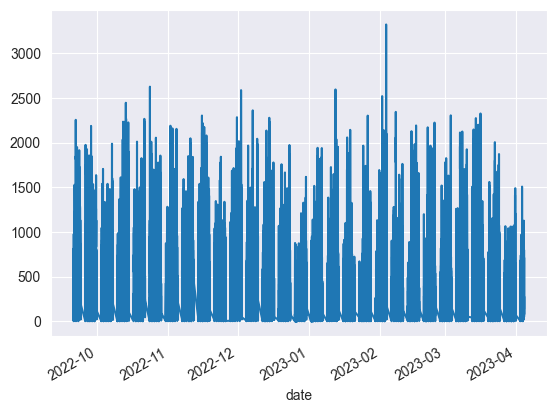

In [51]:
df['volume'].plot()

<Axes: xlabel='date'>

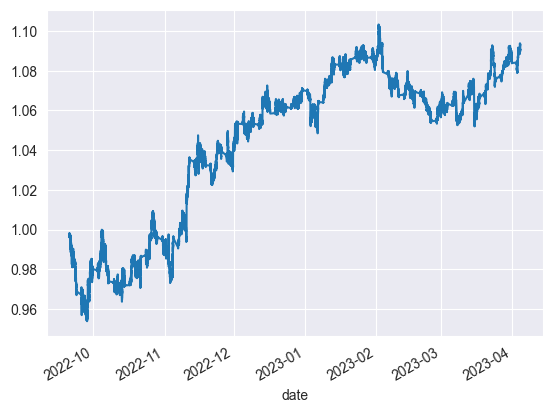

In [52]:
df['close'].plot()